In [ ]:
"""
Project: Connecting Local CSV (Amazon Product Reviews) to the Azure SQL Database using Python, and Microsoft SQL Server Management Studio
Programmer: Nishigandha Wankhade

Information: 1. Performing ETL(Extract- Transform - Load), and moving data from a local CSV file into Azure SQL Database using Python.
             2. Multi-class Logistic Regression
             3. Confusion Matrix for Multi-class classifier
             4. TF-IDF Word Cloud for Multi-class scenario

"""

In [ ]:
"""
Before doing this, make sure you have configured the Azure SQL database.
"""

In [ ]:
#================= STEP 1 : installing required libraries ======================
!pip install pandas sqlalchemy pyodbc         
"""
There are three libraries required for connecting Python to Azure SQL Database and 
transferring CSV data into SQL.
1.pandas: useful for loading, and manipulating CSV files into DataFrames.
2.sqlalchemy: helps Python to access SQL database consistently (connection between Python and SQL database).
              Also works with MySQL, SQL Server, PostgreSQL, etc.
3.pyodbc: driver connector needed between Python and Microsoft SQL Server (or Azure SQL) 
"""

In [ ]:
!pip install textblob

In [ ]:
!pip install tensorflow==2.13

In [ ]:
!pip install wordcloud

In [ ]:
!pip install seaborn

In [97]:
import pandas as pd                       # (T) for null handling, date formating, reading csv file
from sqlalchemy import create_engine, event      # (L) to upload cleaned and enriched data to Azure SQL DB
                                        # df.to_sql() sends a DataFrame to SQL
import pyodbc                           # # (L) to upload cleaned and enriched data to Azure SQL DB pyodbc.connect() 
import glob                             # ((E) for reading multiple CSV files from a particular location
import urllib
import numpy as np                     # (T) for feature engineering

from sklearn.feature_extraction.text import TfidfVectorizer  # (T) sklearn for feature engineering
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
#from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder

from wordcloud import WordCloud

from textblob import TextBlob            # (T) for sentiment analysis
import tensorflow as tf                  # (T) to build a ML model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

import re

import seaborn as sns
import matplotlib.pyplot as plt

In [114]:
#================= STEP 2 : Loading Data from multiple CSV files to single DataFrame ======================
"""    
# ============= To read Multiple CSV files =====================================
csv_files = glob.glob("C:/Users/wankh/Desktop/Datasets/AMAZON_PRODUCT_REVIEWS/Product_Analysis/*.csv")

# Read and combine all CSVs into one DataFrame
combined_df = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)
"""

# ========================== To read Single CSV File ============================================
df2 = pd.read_csv('C:\\Users\\wankh\\Desktop\\Datasets\\AMAZON_PRODUCT_REVIEWS\\All_Beauty_5_part0.csv')


In [115]:
#combined_df.head(10)

In [116]:
#combined_df.info()

In [117]:
df2.head(10)

,asin,reviewText,overall,category,summary
0,B0000530HU,As advertised. Reasonably priced,5.0,All_Beauty_5,Five Stars
1,B0000530HU,Like the oder and the feel when I put it on my...,5.0,All_Beauty_5,Good for the face
2,B0000530HU,I bought this to smell nice after I shave. Wh...,1.0,All_Beauty_5,Smells awful
3,B0000530HU,HEY!! I am an Aqua Velva Man and absolutely lo...,5.0,All_Beauty_5,Truth is There IS Nothing Like an AQUA VELVA MAN.
4,B00006L9LC,If you ever want to feel pampered by a shampoo...,5.0,All_Beauty_5,Bvlgari Shampoo
5,B00006L9LC,"If you know the scent of Diva, you'll LOVE thi...",5.0,All_Beauty_5,Diva is Heavenly
6,B00006L9LC,Got this shampoo as a solution for my wife's d...,5.0,All_Beauty_5,"Outstanding, no complains"
7,B00006L9LC,No change my scalp still itches like crazy. It...,2.0,All_Beauty_5,No change my scalp still itches like crazy. It...
8,B00006L9LC,Too expensive for such poor quality. There was...,1.0,All_Beauty_5,Too expensive for such poor quality. There was...
9,B00006L9LC,"It dries my hair, doesnt help to reduce dandru...",1.0,All_Beauty_5,"Dries my hair, doesnt help to reduce dandruff...."


In [118]:
# ========================== STEP 3:  SELECTING RELEVANT COLUMNS =================================
#df = combined_df[['reviewText', 'overall', 'category', 'summary']]  # select relevant columns
df = df2[['reviewText', 'overall', 'category', 'summary']].copy()  # create a copy with selected and relevant columns

df['reviewText'] = df['reviewText'].fillna('')   # for handling missing text
df = df.dropna().copy()   # dropping rows with other missing fields

In [119]:
# ====================== STEP 4: SENTIMENT ANALYSIS Using TextBlob===========================
def get_sentiment_and_score(text):
    analysis = TextBlob(str(text))
    polarity = analysis.sentiment.polarity
    label = 'positive' if polarity > 0 else 'negative' if polarity < 0 else 'neutral'
    return pd.Series([label, polarity])
    
df[['sentiment', 'sentiment_score']] = df['reviewText'].apply(get_sentiment_and_score)


In [120]:
df.head(10)

,reviewText,overall,category,summary,sentiment,sentiment_score
0,As advertised. Reasonably priced,5.0,All_Beauty_5,Five Stars,positive,0.200000
1,Like the oder and the feel when I put it on my...,5.0,All_Beauty_5,Good for the face,negative,-0.028125
2,I bought this to smell nice after I shave. Wh...,1.0,All_Beauty_5,Smells awful,negative,-0.066667
3,HEY!! I am an Aqua Velva Man and absolutely lo...,5.0,All_Beauty_5,Truth is There IS Nothing Like an AQUA VELVA MAN.,positive,0.217406
4,If you ever want to feel pampered by a shampoo...,5.0,All_Beauty_5,Bvlgari Shampoo,positive,0.250000
5,"If you know the scent of Diva, you'll LOVE thi...",5.0,All_Beauty_5,Diva is Heavenly,positive,0.687500
6,Got this shampoo as a solution for my wife's d...,5.0,All_Beauty_5,"Outstanding, no complains",positive,0.583333
7,No change my scalp still itches like crazy. It...,2.0,All_Beauty_5,No change my scalp still itches like crazy. It...,positive,0.021875
8,Too expensive for such poor quality. There was...,1.0,All_Beauty_5,Too expensive for such poor quality. There was...,negative,-0.027778
9,"It dries my hair, doesnt help to reduce dandru...",1.0,All_Beauty_5,"Dries my hair, doesnt help to reduce dandruff....",positive,0.016667


In [121]:
#===================== STEP 5: ADDING MORE INFORMATION FOR BETTER ANALYTICS =========================
# ======================= CHARACTER COUNT ============================
df['review_length'] = df['reviewText'].apply(lambda x: len(str(x)))

# ====================== WORD COUNT =================================
df['word_count'] = df['reviewText'].apply(lambda x: len(str().split(x)))

# ===================== EXCLAMATION COUNT ==============================
df['exclamation_count'] = df['reviewText'].apply(lambda x: x.count('!'))

In [122]:
df.head(5)

,reviewText,overall,category,summary,sentiment,sentiment_score,review_length,word_count,exclamation_count
0,As advertised. Reasonably priced,5.0,All_Beauty_5,Five Stars,positive,0.200000,32,1,0
1,Like the oder and the feel when I put it on my...,5.0,All_Beauty_5,Good for the face,negative,-0.028125,207,1,0
2,I bought this to smell nice after I shave. Wh...,1.0,All_Beauty_5,Smells awful,negative,-0.066667,142,1,0
3,HEY!! I am an Aqua Velva Man and absolutely lo...,5.0,All_Beauty_5,Truth is There IS Nothing Like an AQUA VELVA MAN.,positive,0.217406,1417,1,2
4,If you ever want to feel pampered by a shampoo...,5.0,All_Beauty_5,Bvlgari Shampoo,positive,0.250000,237,1,1


In [123]:
# Before executing this, make sure you have connected Microsoft SQL Server Management Studio to the Azure SQL Database
# and the Azure SQL Database status must be "Online" to establish the connection successfully 

#================= STEP 6: Preparing Azure SQL Connection String ======================

server = 'azuresrvdemo.database.windows.net'      # server name from Azure SQL database
database = 'azuredemodb'                          # Database name given at the time of creation of the Azure SQL database
username = 'azuredemoadmin'                       # Admin credentials given at the time of Azure Database creation
password = 'azureDemoPass%2A'                     # Admin password given at the time of Azure Database creation
driver = 'ODBC+Driver+17+for+SQL+Server'


# URL-encode the full string automatically (preferred method)
params = urllib.parse.quote_plus(
    
    f'driver=ODBC Driver 17 for SQL Server;SERVER={server};DATABASE={database};UID={username};PWD={password}'
)


# Create the connection URL
connection_url = f'mssql+pyodbc://{username}:{password}@{server}:1433/{database}?driver={driver.replace(" ", "+")}'

# Create SQLAlchemy engine
engine = create_engine(connection_url)


# Test the connection
with engine.connect() as conn:
    print("✅ Connected successfully")

✅ Connected successfully


In [ ]:

"""
# ==================== OPTIONAL: Improve speed + avoid memory errors ==========================
@event.listens_for(engine, "before_cursor_execute")
def receive_before_cursor_execute(conn, cursor, statement, params, context, executemany):
    cursor.fast_executemany = True
"""


"""
# =============   OPTIONAL: If any ProblemS arises during connection...use the following =======================
def get_engine():
    conn_str = "mssql+pyodbc://<username>:<password>@<server>:1433/<database>?driver=ODBC+Driver+17+for+SQL+Server"
    return create_engine(conn_str, fast_executemany=True)

# Create fresh engine before each insert
engine = get_engine()
"""

"""
# ========================== To Rollback Any Pending Transaction =================
with engine.connect() as conn:
    trans = conn.begin()
    try:
        # nothing to do, just roll back
        trans.rollback()
        print("Transaction rolled back successfully.")
    except:
        print("Rollback failed.")
"""


In [131]:
#================= STEP 7 : Uploading DataFrame to Azure SQL Table ======================
try:
    
    # This will create a table called 'amazon_reviews' and upload data
    # If it won't work, then before executing the below line of code, create a table named "amazon_reviews" schema in SSMS (Micrsoft SQL Server Management Studio)
    """
    create table amazon_reviews(
        reviewText VARCHAR(255),
        overall FLOAT,
        category VARCHAR(50),
        summary VARCHAR(255),
        sentiment VARCHAR(20),
        sentiment_score FLOAT,
        review_length INT,
        word_count INT,
        exclamation_count INT
    );
"""

    
    #combined_df.to_sql('amazon_reviews', con=engine, if_exists='replace', index=False)  #if_exists='append' , if you want to append new data into existing table
    df.to_sql('amazon_reviews', con=engine, if_exists='replace', index=False)
    print("✅ Data uploaded successfully!")
except Exception as e:
    print("❌ Upload failed:", e)

✅ Data uploaded successfully!


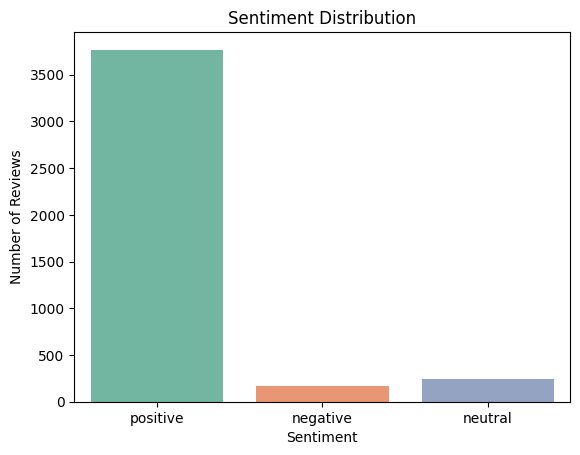

In [126]:
# =============  BAR PLOT for Sentiment counts (How mant "positive" Vs. "negative" reviews exist)  ============================
# import matplotlib.pyplot as plt
# import seaborn as sns

sns.countplot(x = 'sentiment', hue='sentiment', data = df, palette = 'Set2')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

In [127]:
#================ MULTI-CLASS LOGISTIC REGRESSION (Sentiment Classifier)==========================
x = df['reviewText']
#y = df['sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})   # if you want to map classes into numerical form
y = df['sentiment']  # to use classes in text form

# =============================== FOR TF-IDF VECTORIZAION =================================
# Instantiation
tfidf = TfidfVectorizer()

# Fit-transform the reviewText column
x_vect = tfidf.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_vect, y, test_size = 0.2, random_state = 42)
#model = LogisticRegression()
model = LogisticRegression(solver='lbfgs', max_iter = 1000)  # no need to specify multi_class = 'multinomial' as scikit-learn will always use 'multinomial' internally from version 1.7
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

    negative       1.00      0.26      0.41        39
     neutral       0.93      0.49      0.64        57
    positive       0.93      1.00      0.96       741

    accuracy                           0.93       837
   macro avg       0.95      0.58      0.67       837
weighted avg       0.93      0.93      0.91       837



In [128]:
print(set(y_test))
print(set(y_pred))

{'positive', 'negative', 'neutral'}
{'positive', 'negative', 'neutral'}


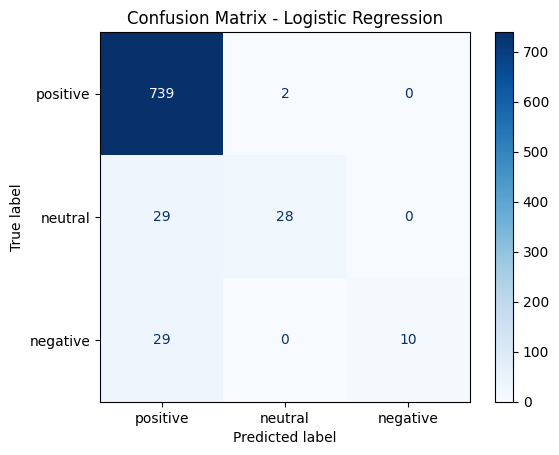

In [129]:
# ========================= Confusion Matrix for Multi-class Logistic Regression =========================
#from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#labels = [1, 0, -1]  # numeric labels of 'positive', 'neutral', and 'negative' respectively
labels = ['positive', 'neutral', 'negative']

cm = confusion_matrix(y_test, y_pred, labels = labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)

disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

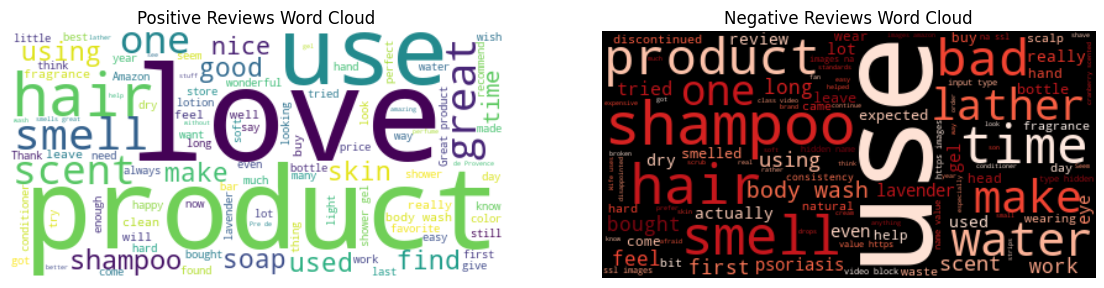

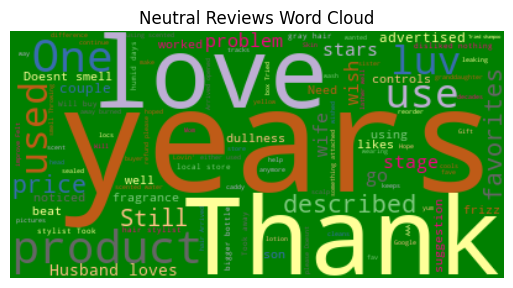

In [130]:
#===================== TF-IDF WORD CLOUD for Multi-class =============================
from wordcloud import WordCloud

positive_text = ' '.join(df[df['sentiment']=='positive']['reviewText'])
negative_text = ' '.join(df[df['sentiment']=='negative']['reviewText'])
neutral_text = ' '.join(df[df['sentiment']=='neutral']['reviewText'])

wordcloud_pos = WordCloud(max_words=100, background_color='white').generate(positive_text)
wordcloud_neg = WordCloud(max_words=100, background_color='black', colormap='Reds').generate(negative_text)
wordcloud_neu = WordCloud(max_words=100, background_color='green', colormap='Accent').generate(neutral_text)


# Plot both
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title("Positive Reviews Word Cloud")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title("Negative Reviews Word Cloud")
plt.axis("off")
plt.show()

plt.figure(figsize=(14,6))
plt.subplot(1,2,2)
plt.imshow(wordcloud_neu, interpolation='bilinear')
plt.title("Neutral Reviews Word Cloud")
plt.axis("off")
plt.show()